_Version log: Branch of V24. Changing the SA objective from minimising error to minimising redundant baselines._

In [600]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [601]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, reduced_points, subsampling_method = "random"):

    if subsampling_method == "random":
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

In [602]:
file_name = "1dmockanderrors2"
file_type = ".csv"
iterations = 50000
cooling = 0.99995
total_points = 50
reduced_points = 9
max_temp = reduced_points
regularization_coeffient = 1e-4 # DECREASE FOR 'COMPLEX' IMAGES (up to 1e-7) INCREASE FOR 'SIMPLE' IMAGES (up to 1e-2)
min_seperation = 1 #pixels


dataset = open_dataset(file_name, file_type)
target = interpolate(dataset[0], total_points)
uncertainties = interpolate(dataset[1], total_points)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)

In [603]:
detectors = original_detectors = subsample_1d(total_points, reduced_points, subsampling_method= "regular")

print(total_points, reduced_points)

50 9


In [604]:
#########INITAILISATION##########
#result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)

scores = np.array([])
temps = []

### Autocorrelation
array = np.zeros_like(target)
array[detectors] = 1.
autocorrelation = np.correlate(array, array, mode='full')
score = np.sum((autocorrelation-1)**2)
#score = np.count_nonzero(autocorrelation == 0) #This is the number of redundant baselines

#score = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved

    #new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)

    ### Autocorrelation
    array = np.zeros_like(target)
    array[new_detectors] = 1.
    new_autocorrelation = np.correlate(array, array, mode='full')
    new_score = np.sum((new_autocorrelation-1)**2)
    #new_score = np.count_nonzero(autocorrelation == 0) #This is the number of redundant baselines

    #new_score = np.linalg.norm((target -new_result) /uncertainties) #This is the chi-squared

    if new_score < score:
        detectors = new_detectors
        autocorrelation = new_autocorrelation
        #result = new_result
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

100%|██████████| 50000/50000 [00:16<00:00, 3095.96it/s]


In [605]:
frequent_temps = np.array(np.unique(temps[1], return_counts=True)).T
frequent_temps = frequent_temps[frequent_temps[:, 1].argsort()[::-1]]
frequent_temps[:5]

array([[2.0000e+00, 1.1709e+04],
       [1.0000e+00, 9.5930e+03],
       [3.0000e+00, 8.7750e+03],
       [5.0000e+00, 6.4160e+03],
       [4.0000e+00, 5.8340e+03]])

In [606]:
scores

array([158., 158., 138., ...,  98.,  98.,  98.])

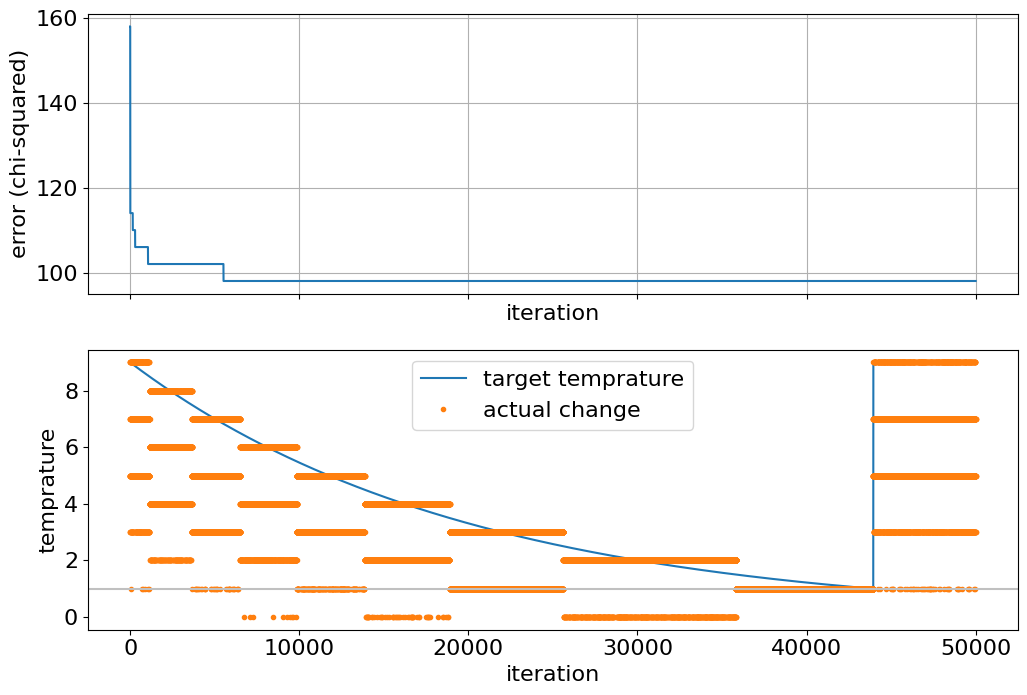

best score = 98.000


In [607]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

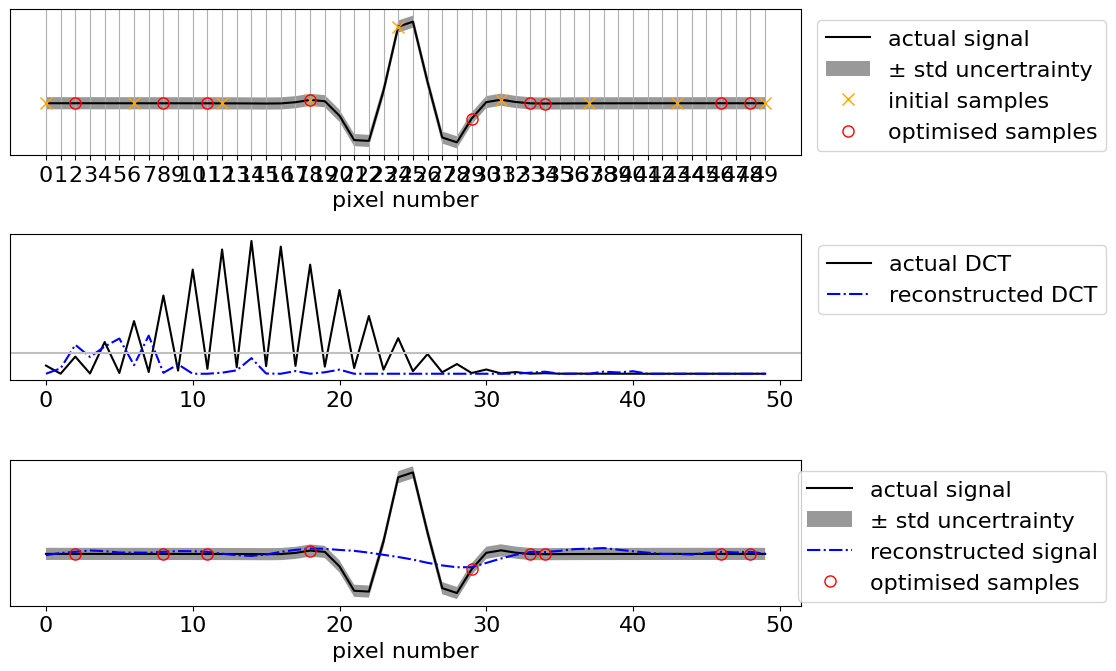

In [608]:
result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)

result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")

threshold = np.abs(target_DCT).mean()

plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[0].plot(original_detectors, target[original_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number", xticks= np.arange(total_points))
axs[0].grid(True)

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")
axs[1].hlines(threshold, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")

axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")

#axs[2].plot(detectors, binned_mean(detectors, target, detector_size), marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()


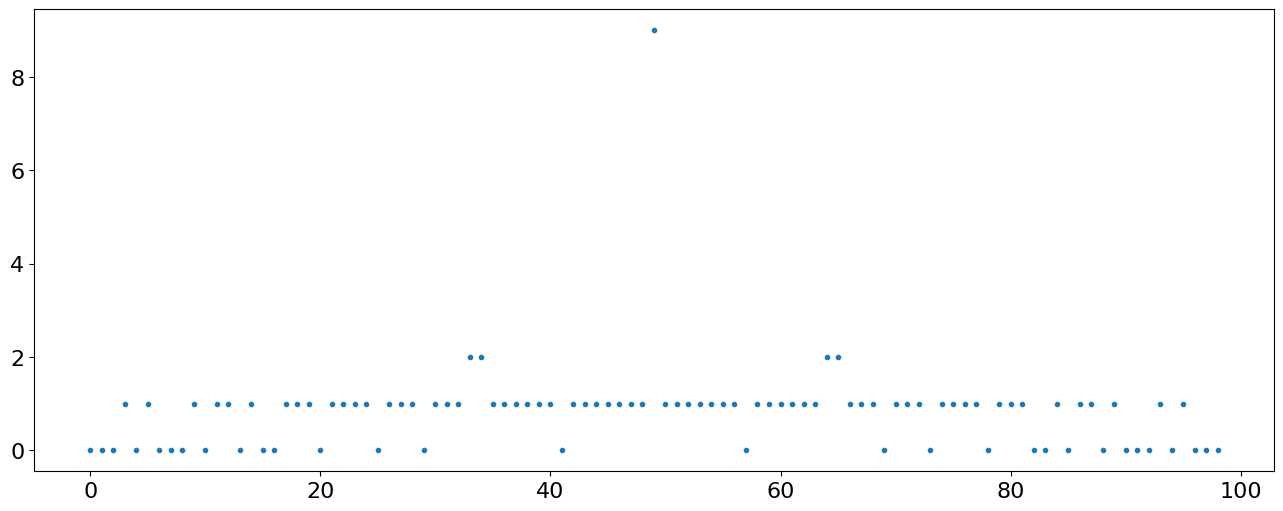

In [609]:
fig, axs = plt.subplots(figsize= (16, 6))

axs.plot(autocorrelation, marker= ".", linestyle= "none")

plt.show()

In [695]:
n = 70
a = [0,1,4,10,21,40,-30,-16,-8,-3,-1]

b = np.zeros(n)
b[a] = 1.

print(len(b), len(a))
print(np.nonzero(b)[0])
print(n -np.nonzero(b)[0] -1)
print(np.correlate(b, b, mode= "full"))
print(np.count_nonzero(np.correlate(b, b, mode= "full") > 1))

70 11
[ 0  1  4 10 21 40 54 62 67 69]
[69 68 65 59 48 29 15  7  2  0]
[ 1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.
  0.  1.  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  0.
  1.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 10.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.
  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.]
1


In [611]:
np.count_nonzero(autocorrelation == 0)

30

In [612]:
np.sum((autocorrelation-1)**2)

98.0